In [1]:
from src.scripts.utils import get_test_loader, evaluate_model
from src.models.geovae.geovae import GeoVAE
import torch

test_loader = get_test_loader('thetthetyee/celaba-face-recognition', 
                              raw_dir="data/raw_data/celaba/raw",
        split_dir="data/data_splits/celaba")

geovae = GeoVAE(
    input_dim=3,
    hidden_dim=128,
    residual_hiddens=64,
    num_residual_layers=1,
    latent_dim=64,
    image_size=64,
)
geovae.load_state_dict(torch.load('models/reconstruction/geovae/GeoVAE_layers1_latent64_datasetthetthetyee_celaba-face-recognition.pt', map_location='cpu'))


evaluate_model(geovae, test_loader, 'cpu')


/home/nikodem/Workspace/1-sem-mgr/GeoVAE/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[INFO] Dataset 'thetthetyee/celaba-face-recognition' already exists at data/raw_data/celaba/raw, skipping copy.
Test MSE: 0.0081
Test SSIM: 0.6493
Test PSNR: 21.3905


In [ ]:
from src.scripts.utils import get_test_loader, evaluate_model
from src.models.dummy_geovae.geovae import DummyGeoVAE
import torch

test_loader = get_test_loader('thetthetyee/celaba-face-recognition', 
                              raw_dir="data/raw_data/celaba/raw",
        split_dir="data/data_splits/celaba")

dummy_geovae = DummyGeoVAE(
    input_dim=3,
    hidden_dim=128,
    residual_hiddens=64,
    num_residual_layers=1,
    latent_dim=64,
    image_size=64,
)
dummy_geovae.load_state_dict(torch.load('models/reconstruction/dummy_geovae/DummyGeoVAE_layers1_latent64_datasetthetthetyee_celaba-face-recognition.pt', map_location='cpu'))


evaluate_model(dummy_geovae, test_loader, 'cpu')

[INFO] Dataset 'thetthetyee/celaba-face-recognition' already exists at data/raw_data/celaba/raw, skipping copy.
Test MSE: 0.0081
Test SSIM: 0.6483
Test PSNR: 21.3758


In [2]:
from src.scripts.utils import get_test_loader, evaluate_model
from src.models.geovae.geovae import GeoVAE
import torch

test_loader = get_test_loader('thetthetyee/celaba-face-recognition', 
                              raw_dir="data/raw_data/celaba/raw",
        split_dir="data/data_splits/celaba")

geovae = GeoVAE(
    input_dim=3,
    hidden_dim=128,
    residual_hiddens=64,
    num_residual_layers=1,
    latent_dim=64,
    image_size=64,
)
geovae.load_state_dict(torch.load('models/reconstruction/geovae/GeoVAE_layers1_latent64_datasetthetthetyee_celaba-face-recognition.pt', map_location='cpu'))


evaluate_model(geovae, test_loader, 'cpu')


[INFO] Dataset 'thetthetyee/celaba-face-recognition' already exists at data/raw_data/celaba/raw, skipping copy.
Test MSE: 0.0082
Test SSIM: 0.6460
Test PSNR: 21.3443


In [2]:
from src.scripts.utils import get_test_loader, evaluate_model, get_train_loader
from src.models.geovae.geovae import GeoVAE
import torch

geovae = GeoVAE(
    input_dim=3,
    hidden_dim=128,
    residual_hiddens=64,
    num_residual_layers=1,
    latent_dim=64,
    image_size=64,
)
geovae.load_state_dict(torch.load('models/reconstruction/geovae/GeoVAE_layers1_latent64_datasetthetthetyee_celaba-face-recognition.pt', map_location='cpu'))

train_loader = get_train_loader('thetthetyee/celaba-face-recognition', 
                              raw_dir="data/raw_data/celaba/raw",
        split_dir="data/data_splits/celaba")


[INFO] Dataset 'thetthetyee/celaba-face-recognition' already exists at data/raw_data/celaba/raw, skipping copy.


Min: -0.021831253543496132
Max: 0.002779412781819701
Std: 0.005790104158222675


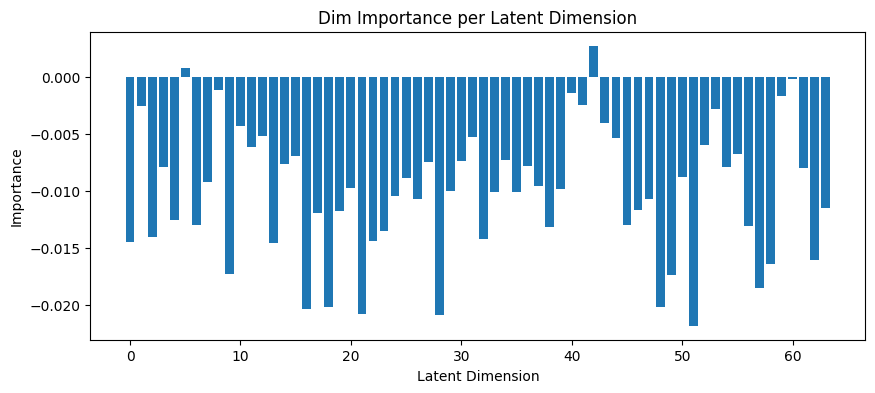

In [3]:
import torch
import matplotlib.pyplot as plt

geovae.eval()

x, _ = next(iter(train_loader))
with torch.no_grad():
    dim_importance = geovae.compute_dim_gnn()

print("Min:", dim_importance.min().item())
print("Max:", dim_importance.max().item())
print("Std:", dim_importance.std().item())

plt.figure(figsize=(10, 4))
plt.bar(range(len(dim_importance)), dim_importance.cpu().numpy())
plt.title("Dim Importance per Latent Dimension")
plt.xlabel("Latent Dimension")
plt.ylabel("Importance")
plt.show()

MUS MAX: 2.865809202194214
MUS MIN: -2.5810248851776123
MUS STD: 0.4820961058139801


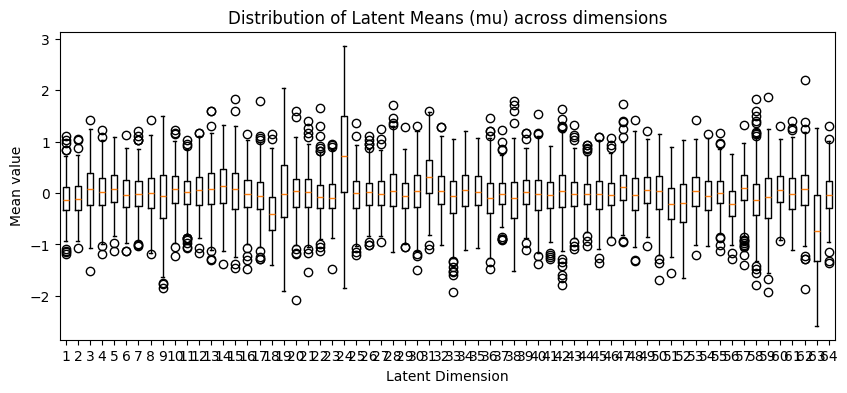

In [6]:
mus = []
with torch.no_grad():
    for x, _ in train_loader:
        mu, _ = geovae.encode(x)
        mus.append(mu)
        if len(mus) > 10:  # wystarczy 10 batchy
            break
mus = torch.cat(mus, dim=0)

print(f'MUS MAX: {mus.max()}')
print(f'MUS MIN: {mus.min()}')
print(f'MUS STD: {mus.std()}')

plt.figure(figsize=(10,4))
plt.boxplot(mus.cpu().numpy())
plt.title("Distribution of Latent Means (mu) across dimensions")
plt.xlabel("Latent Dimension")
plt.ylabel("Mean value")
plt.show()


In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from sklearn.decomposition import PCA


# =====================================================
# 1. Pairwise GNN influence diagnostics
# =====================================================
def analyze_scores_distribution(geovae, x, threshold=0.5, device="cpu"):
    geovae.eval()
    with torch.no_grad():
        mu, _ = geovae.encode(x.to(device))
        B = mu.size(0)

        edge_index = geovae._init_chain_tree_edge_index(B)
        v_inst = geovae.compute_instance_gnn(mu, edge_index)
        dim_importance = geovae.compute_dim_gnn()
        v = v_inst * dim_importance.view(1, -1)

        # --- safer similarity computation ---
        v_norm = F.normalize(v, p=2, dim=1)  # [B, D]
        scores = torch.matmul(v_norm, v_norm.T).cpu().numpy()  # cosine sim ∈ [-1,1]

        # clean up any NaNs
        scores = np.nan_to_num(scores, nan=0.0, posinf=0.0, neginf=0.0)

        flat_scores = scores[np.triu_indices(B, k=1)]

        if not np.isfinite(flat_scores).any():
            print("[Warning] All scores are NaN or inf — skipping histogram.")
            return

    plt.figure(figsize=(6, 4))
    plt.hist(flat_scores, bins=20, color='skyblue', edgecolor='black')
    plt.title("Distribution of pairwise cosine similarities (v_i, v_j)")
    plt.xlabel("Cosine similarity")
    plt.ylabel("Frequency")
    plt.show()

    print(f"[Scores] Mean={flat_scores.mean():.3f}, Std={flat_scores.std():.3f}, "
          f"Min={flat_scores.min():.3f}, Max={flat_scores.max():.3f}")

    src, dst = np.where(scores > threshold)
    density = len(src) / (B ** 2)
    print(f"[Graph Density] {density:.3f}")



# =====================================================
# 2. Graph connectivity based on actual GNN edges
# =====================================================
def analyze_graph_connectivity(geovae, x, threshold=0.5, device="cpu"):
    geovae.eval()
    with torch.no_grad():
        mu, _ = geovae.encode(x.to(device))
        edge_index = geovae._init_chain_tree_edge_index(mu.size(0))
        v_inst = geovae.compute_instance_gnn(mu, edge_index)

    G = nx.Graph()
    for i, j in edge_index.T.cpu().numpy():
        G.add_edge(int(i), int(j))

    components = nx.number_connected_components(G)
    print(f"[Connectivity] Connected components: {components}")

    if components > 1:
        print("Graph is disconnected — check GCN edge weights or instance threshold.")


# =====================================================
# 3. Latent transformation magnitude through GNN
# =====================================================
def analyze_latent_change(geovae, x, device="cpu"):
    geovae.eval()
    with torch.no_grad():
        mu, _ = geovae.encode(x.to(device))
        edge_index = geovae._init_chain_tree_edge_index(mu.size(0))

        h1 = F.relu(geovae.inst_convs[0](mu, edge_index))
        for conv in geovae.inst_convs[1:]:
            h1 = F.relu(conv(h1, edge_index))

        diff = (h1 - mu).abs().mean().item()
        print(f"[Latent change] Mean absolute change per dim: {diff:.4f}")
    return diff


def visualize_latent_graph(geovae, x, threshold=0.5, device="cpu"):
    geovae.eval()
    with torch.no_grad():
        mu, _ = geovae.encode(x.to(device))
        edge_index = geovae._init_chain_tree_edge_index(mu.size(0))
        v_inst = geovae.compute_instance_gnn(mu, edge_index)
        dim_importance = geovae.compute_dim_gnn()

    mu_2d = PCA(2).fit_transform(mu.cpu().numpy())
    plt.figure(figsize=(6, 6))
    plt.scatter(mu_2d[:, 0], mu_2d[:, 1], c='blue', label="μ")
    plt.title("Latent Graph (μ) after GNN update")

    # Draw instance edges
    for i, j in edge_index.T.cpu().numpy():
        plt.plot([mu_2d[i, 0], mu_2d[j, 0]], [mu_2d[i, 1], mu_2d[j, 1]], 'gray', alpha=0.3)

    plt.legend()
    plt.show()

    # Plot dimension importance
    plt.figure(figsize=(6, 3))
    plt.bar(np.arange(len(dim_importance)), dim_importance.cpu().numpy())
    plt.title("Dimension importance (from Dim-GNN)")
    plt.xlabel("Latent dim")
    plt.ylabel("Importance")
    plt.show()


def analyze_reconstruction_effect(geovae, x, device="cpu"):
    geovae.eval()
    with torch.no_grad():
        mu, sigma = geovae.encode(x.to(device))
        edge_index = geovae._init_chain_tree_edge_index(mu.size(0))
        v_inst = geovae.compute_instance_gnn(mu, edge_index)
        dim_importance = geovae.compute_dim_gnn()
        v = v_inst * dim_importance.view(1, -1)

        eps = torch.randn_like(mu)
        z_gnn = mu + sigma * (eps * v)
        z_plain = mu + sigma * eps

        recon_gnn = geovae.decode(z_gnn)
        recon_plain = geovae.decode(z_plain)

    mse_diff = ((recon_gnn - recon_plain) ** 2).mean().item()
    print(f"[Reconstruction Δ] MSE diff (with vs without GNN): {mse_diff:.6f}")
    return mse_diff


def run_full_optimizer_analysis(geovae, loader, device="cpu", threshold=0.5):
    x, _ = next(iter(loader))
    x = x[:8].to(device)

    print("\nStarting GeoVAE Internal Diagnostics (original-style)...\n")

    analyze_scores_distribution(geovae, x, threshold, device)
    analyze_graph_connectivity(geovae, x, threshold, device)
    analyze_latent_change(geovae, x, device)
    visualize_latent_graph(geovae, x, threshold, device)
    analyze_reconstruction_effect(geovae, x, device)

    print("\nDiagnostics complete.\n")



🚀 Starting GeoVAEOptimizer Diagnostics...



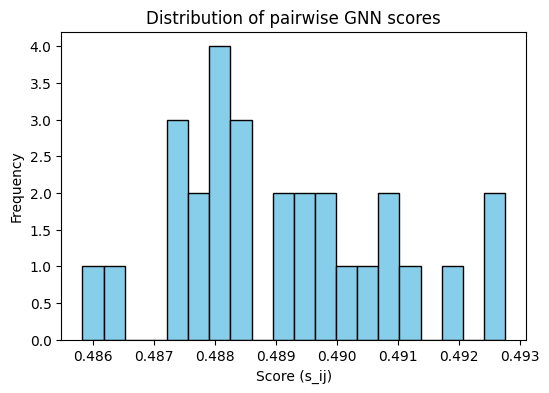

[Scores] Mean=0.489, Std=0.002, Min=0.486, Max=0.493
[Graph Density] 0.000
[Connectivity] Connected components: 1
[Latent change] Mean absolute change per dim: 0.3814


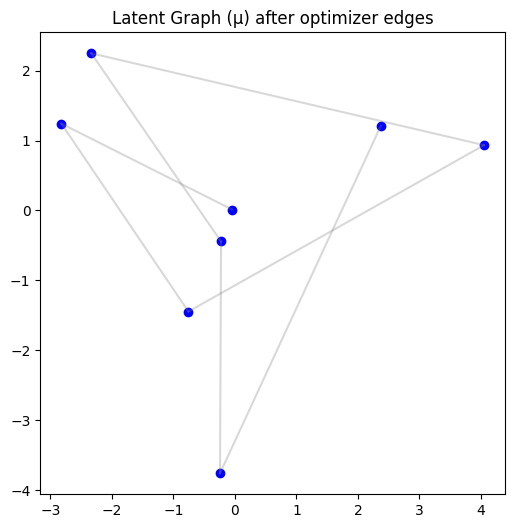

[MST edges] 7 (expected 7)
[Reconstruction Δ] MSE diff (orig vs optimized): 0.000000

Analysis complete.


In [17]:
run_full_optimizer_analysis(geovae, train_loader)


🚀 Starting GeoVAEOptimizer Diagnostics...



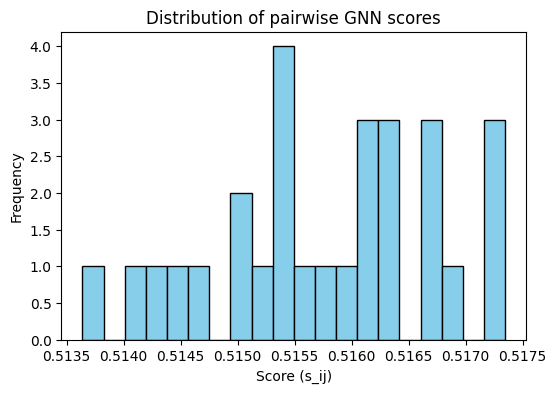

[Scores] Mean=0.516, Std=0.001, Min=0.514, Max=0.517
[Graph Density] 0.875
[Connectivity] Connected components: 1
[Latent change] Mean absolute change per dim: 0.2769


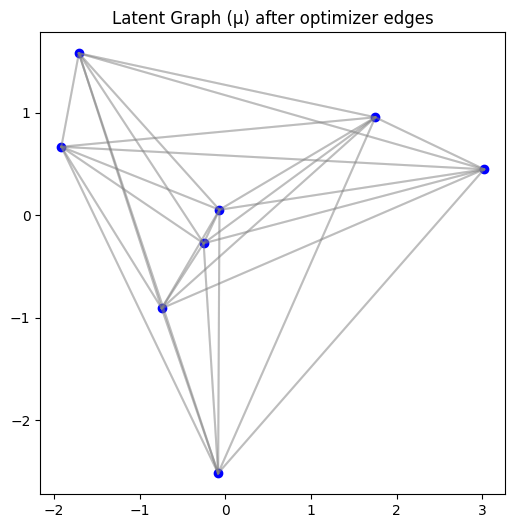

[MST edges] 7 (expected 7)
[Reconstruction Δ] MSE diff (orig vs optimized): 0.000000

Analysis complete.


In [18]:
tree_geovae = GeoVAE(
    input_dim=3,
    hidden_dim=128,
    residual_hiddens=64,
    num_residual_layers=1,
    latent_dim=64,
    image_size=64,
)
tree_geovae.load_state_dict(torch.load('models/reconstruction/geovae/TREE_GeoVAE_layers1_latent64_datasetthetthetyee_celaba-face-recognition.pt', map_location='cpu'))
run_full_optimizer_analysis(tree_geovae, train_loader)

[INFO] Dataset 'thetthetyee/celaba-face-recognition' already exists at data/raw_data/celaba/raw, skipping copy.

🚀 Starting GeoVAEOptimizer Diagnostics...



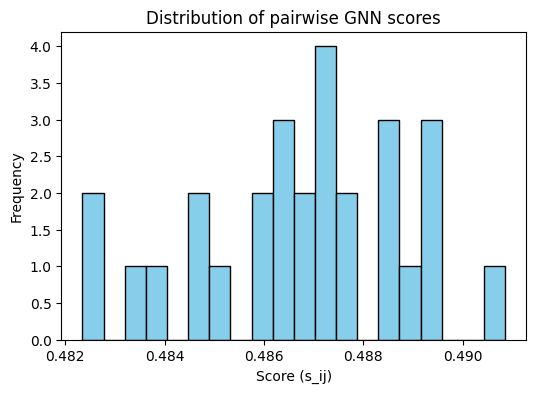

[Scores] Mean=0.487, Std=0.002, Min=0.482, Max=0.491
[Graph Density] 0.000
[Connectivity] Connected components: 1
[Latent change] Mean absolute change per dim: 0.3214


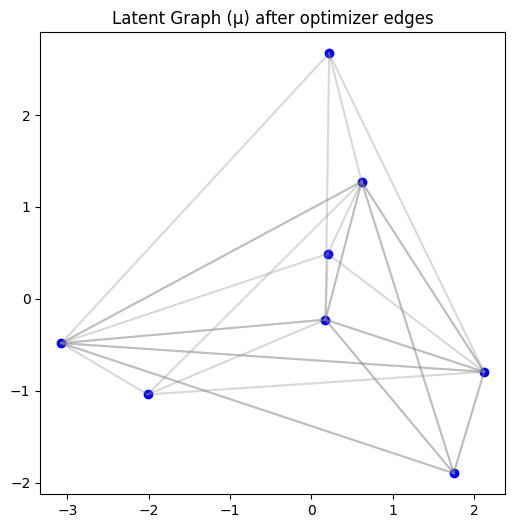

[Reconstruction Δ] MSE diff (orig vs optimized): 0.000000

Analysis complete.


In [12]:
from src.scripts.utils import get_test_loader, evaluate_model, get_train_loader
from src.models.geovae.geovae import GeoVAE
import torch

geovae = GeoVAE(
    input_dim=3,
    hidden_dim=128,
    residual_hiddens=64,
    num_residual_layers=1,
    latent_dim=64,
    image_size=64,
)

geovae.load_state_dict(torch.load('models/reconstruction/geovae/GeoVAE_layers1_latent64_datasetthetthetyee_celaba-face-recognition.pt', map_location='cpu'))


train_loader = get_train_loader('thetthetyee/celaba-face-recognition', 
                              raw_dir="data/raw_data/celaba/raw",
        split_dir="data/data_splits/celaba")

run_full_optimizer_analysis(geovae, train_loader)

In [2]:
from src.scripts.utils import get_test_loader, evaluate_model
from src.models.geovae.geovae import GeoVAE
import torch

test_loader = get_test_loader('thetthetyee/celaba-face-recognition', raw_dir="data/raw_data/celaba/raw", split_dir="data/data_splits/celaba")

geovae = GeoVAE(
    input_dim=3,
    hidden_dim=128,
    residual_hiddens=64,
    num_residual_layers=1,
    latent_dim=64,
    image_size=64,
)
geovae.load_state_dict(torch.load('models/reconstruction/geovae/GeoVAE_layers1_latent64_datasetthetthetyee_celaba-face-recognition.pt', map_location='cpu'))


evaluate_model(geovae, test_loader, 'cpu')

[INFO] Dataset 'thetthetyee/celaba-face-recognition' already exists at data/raw_data/celaba/raw, skipping copy.
Test MSE: 0.0081
Test SSIM: 0.6494
Test PSNR: 21.3866


[INFO] Dataset 'thetthetyee/celaba-face-recognition' already exists at data/raw_data/celaba/raw, skipping copy.

Starting GeoVAE Internal Diagnostics (original-style)...



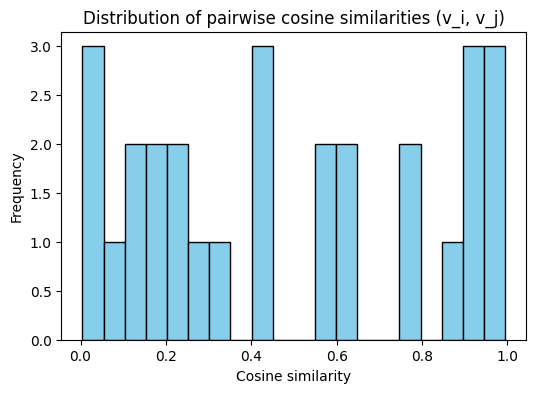

[Scores] Mean=0.485, Std=0.342, Min=0.004, Max=0.995
[Graph Density] 0.531
[Connectivity] Connected components: 1
[Latent change] Mean absolute change per dim: 0.2543


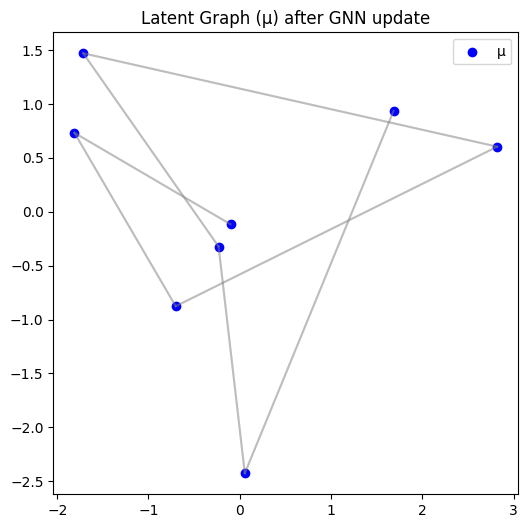

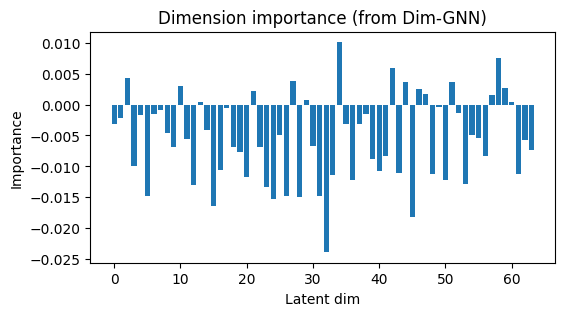

[Reconstruction Δ] MSE diff (with vs without GNN): 0.491400

Diagnostics complete.



In [5]:
from src.scripts.utils import get_train_loader


train_loader = get_train_loader('thetthetyee/celaba-face-recognition', 
                              raw_dir="data/raw_data/celaba/raw",
        split_dir="data/data_splits/celaba")

run_full_optimizer_analysis(geovae, train_loader)

In [2]:
from src.scripts.utils import evaluate_model, get_test_loader
from src.models.geovae.geovae import GeoVAE
import torch

geovae = GeoVAE(
    input_dim=3,
    hidden_dim=128,
    residual_hiddens=64,
    num_residual_layers=1,
    latent_dim=64,
    image_size=64,
)
geovae.load_state_dict(torch.load('models/reconstruction/geovae/GeoVAE_layers1_latent64_datasetmahmudulhaqueshawon_cat-image.pt', map_location='cpu'))

test_loader = get_test_loader('mahmudulhaqueshawon/cat-image', 
                              raw_dir="data/raw_data/cats/raw",
        split_dir="data/data_splits/cats")

evaluate_model(geovae, test_loader, 'cpu')


[INFO] Dataset 'mahmudulhaqueshawon/cat-image' already exists at data/raw_data/cats/raw, skipping copy.
Test MSE: 0.0091
Test SSIM: 0.5268
Test PSNR: 21.0036


In [6]:
from src.scripts.utils import get_test_loader, evaluate_model
from src.models.dummy_geovae.geovae import DummyGeoVAE
import torch

test_loader = get_test_loader('mahmudulhaqueshawon/cat-image', 
                              raw_dir="data/raw_data/cats/raw",
        split_dir="data/data_splits/cats")

dummy_geovae = DummyGeoVAE(
    input_dim=3,
    hidden_dim=128,
    residual_hiddens=64,
    num_residual_layers=1,
    latent_dim=64,
    image_size=64,
)
dummy_geovae.load_state_dict(torch.load('models/reconstruction/dummy_geovae/DummyGeoVAE_layers1_latent64_datasetmahmudulhaqueshawon_cat-image.pt', map_location='cpu'))


evaluate_model(dummy_geovae, test_loader, 'cpu')

[INFO] Dataset 'mahmudulhaqueshawon/cat-image' already exists at data/raw_data/cats/raw, skipping copy.
Test MSE: 0.0092
Test SSIM: 0.5235
Test PSNR: 20.9528


In [2]:
from src.scripts.utils import evaluate_model, get_test_loader
from src.models.geovae.geovae import GeoVAE
from src.models.geovae.geovae import GeoVAE, GraphConvType

import torch

geovae = GeoVAE(
    input_dim=3,
    hidden_dim=128,
    residual_hiddens=64,
    num_residual_layers=1,
    latent_dim=64,
    image_size=64,
    graph_conv_type=GraphConvType.GAT
)
geovae.load_state_dict(torch.load('models/reconstruction/geovae/GeoVAE_layers1_latent64_datasetmahmudulhaqueshawon_cat-image.pt', map_location='cpu'))

test_loader = get_test_loader('mahmudulhaqueshawon/cat-image', 
                              raw_dir="data/raw_data/cats/raw",
        split_dir="data/data_splits/cats")

evaluate_model(geovae, test_loader, 'cpu')


[INFO] Dataset 'mahmudulhaqueshawon/cat-image' already exists at data/raw_data/cats/raw, skipping copy.
Test MSE: 0.0092
Test SSIM: 0.5211
Test PSNR: 20.9901


In [2]:
from src.scripts.utils import evaluate_model, get_test_loader
from src.models.geovae.geovae import GeoVAE
from src.models.geovae.geovae import GeoVAE, GraphConvType

import torch

geovae = GeoVAE(
    input_dim=3,
    hidden_dim=128,
    residual_hiddens=64,
    num_residual_layers=1,
    latent_dim=64,
    image_size=64,
    graph_conv_type=GraphConvType.GST
)
geovae.load_state_dict(torch.load('models/reconstruction/geovae/GeoVAE_layers1_latent64_datasetmahmudulhaqueshawon_cat-image_graph_convGraphConvTypeGST.pt', map_location='cpu'))

test_loader = get_test_loader('mahmudulhaqueshawon/cat-image', 
                              raw_dir="data/raw_data/cats/raw",
        split_dir="data/data_splits/cats")

evaluate_model(geovae, test_loader, 'cpu')

[INFO] Dataset 'mahmudulhaqueshawon/cat-image' already exists at data/raw_data/cats/raw, skipping copy.
Test MSE: 0.0089
Test SSIM: 0.5329
Test PSNR: 21.1289


## VQ-VAE

In [2]:
from src.scripts.utils import evaluate_model, get_test_loader
from src.models.vqvae.vqvae import VQVAE
import torch

vqvae = VQVAE(
    input_dim=3,
    hidden_dim=128,
    residual_hiddens=64,
    num_residual_layers=1,
    image_size=64,
    commitment_cost=0.25,
    num_embeddings=64,
    embedding_dim=32
)
vqvae.load_state_dict(torch.load('models/reconstruction/vqvae/VQVAE_layers1_ne64_ed32_datasetmahmudulhaqueshawon_cat-image.pt', map_location='cpu'))

test_loader = get_test_loader('mahmudulhaqueshawon/cat-image', 
                              raw_dir="data/raw_data/cats/raw",
        split_dir="data/data_splits/cats")

evaluate_model(vqvae, test_loader, 'cpu')

[INFO] Dataset 'mahmudulhaqueshawon/cat-image' already exists at data/raw_data/cats/raw, skipping copy.
Test MSE: 0.0365
Test SSIM: 0.1690
Test PSNR: 14.6011


In [3]:
from src.scripts.utils import get_test_loader, evaluate_model
from src.models.vqvae.vqvae import VQVAE
import torch

test_loader = get_test_loader('thetthetyee/celaba-face-recognition', 
                              raw_dir="data/raw_data/celaba/raw",
        split_dir="data/data_splits/celaba")

vqvae = VQVAE(
    input_dim=3,
    hidden_dim=128,
    residual_hiddens=64,
    num_residual_layers=1,
    image_size=64,
    commitment_cost=0.25,
    num_embeddings=64,
    embedding_dim=32
)
vqvae.load_state_dict(torch.load('models/reconstruction/vqvae/VQVAE_layers1_ne64_ed32_datasetthetthetyee_celaba-face-recognition.pt', map_location='cpu'))


evaluate_model(vqvae, test_loader, 'cpu')

[INFO] Dataset 'thetthetyee/celaba-face-recognition' already exists at data/raw_data/celaba/raw, skipping copy.
Test MSE: 0.0294
Test SSIM: 0.3722
Test PSNR: 15.5819


## VAE

In [6]:
from src.scripts.utils import evaluate_model, get_test_loader
from src.models.vae.vae import VAE
import torch

vae = VAE(
    input_dim=3,
    hidden_dim=128,
    residual_hiddens=64,
    num_residual_layers=1,
    latent_dim=64,
    image_size=64,
)
vae.load_state_dict(torch.load('models/reconstruction/geovae/VAE_layers1_latent64_datasetmahmudulhaqueshawon_cat-image.pt', map_location='cpu'))

test_loader = get_test_loader('mahmudulhaqueshawon/cat-image', 
                              raw_dir="data/raw_data/cats/raw",
        split_dir="data/data_splits/cats")

evaluate_model(vae, test_loader, 'cpu')

[INFO] Dataset 'mahmudulhaqueshawon/cat-image' already exists at data/raw_data/cats/raw, skipping copy.
Test MSE: 0.0103
Test SSIM: 0.4885
Test PSNR: 20.3960


In [7]:
from src.scripts.utils import evaluate_model, get_test_loader
from src.models.vae.vae import VAE
import torch

vae = VAE(
    input_dim=3,
    hidden_dim=128,
    residual_hiddens=64,
    num_residual_layers=1,
    latent_dim=64,
    image_size=64,
)
vae.load_state_dict(torch.load('models/reconstruction/geovae/VAE_layers1_latent64_datasetthetthetyee_celaba-face-recognition.pt', map_location='cpu'))


test_loader = get_test_loader('thetthetyee/celaba-face-recognition', 
                              raw_dir="data/raw_data/celaba/raw",
        split_dir="data/data_splits/celaba")

evaluate_model(vae, test_loader, 'cpu')

[INFO] Dataset 'thetthetyee/celaba-face-recognition' already exists at data/raw_data/celaba/raw, skipping copy.
Test MSE: 0.0090
Test SSIM: 0.6223
Test PSNR: 20.8555


## TreeVI

In [10]:
from src.scripts.utils import evaluate_model, get_test_loader
from src.models.treevi.TreeVAE import TreeVAE
import torch

treeVae = TreeVAE(
    input_dim=3,
    hidden_dim=128,
    residual_hiddens=64,
    num_residual_layers=1,
    latent_dim=64,
    image_size=64,
)
treeVae.load_state_dict(torch.load('models/reconstruction/treevae/TreeVAE_layers1_latent64_datasetmahmudulhaqueshawon_cat-image.pt', map_location='cpu'))

test_loader = get_test_loader('mahmudulhaqueshawon/cat-image', 
                              raw_dir="data/raw_data/cats/raw",
        split_dir="data/data_splits/cats")

evaluate_model(treeVae, test_loader, 'cpu')

[INFO] Dataset 'mahmudulhaqueshawon/cat-image' already exists at data/raw_data/cats/raw, skipping copy.
Test MSE: 0.0108
Test SSIM: 0.4695
Test PSNR: 20.1772


In [11]:
from src.scripts.utils import evaluate_model, get_test_loader
from src.models.treevi.TreeVAE import TreeVAE
import torch

treeVae = TreeVAE(
    input_dim=3,
    hidden_dim=128,
    residual_hiddens=64,
    num_residual_layers=1,
    latent_dim=64,
    image_size=64,
)
treeVae.load_state_dict(torch.load('models/reconstruction/treevae/TreeVAE_layers1_latent64_datasetthetthetyee_celaba-face-recognition.pt', map_location='cpu'))

test_loader = get_test_loader('thetthetyee/celaba-face-recognition', 
                              raw_dir="data/raw_data/celaba/raw",
        split_dir="data/data_splits/celaba")

evaluate_model(treeVae, test_loader, 'cpu')

[INFO] Dataset 'thetthetyee/celaba-face-recognition' already exists at data/raw_data/celaba/raw, skipping copy.
Test MSE: 0.0094
Test SSIM: 0.6189
Test PSNR: 20.6301


In [23]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_metrics_for_dataset(df, dataset_name):
    subset = df[df['Dataset'] == dataset_name]
    metrics = ['MSE', 'SSIM', 'PSNR']

    fig, axes = plt.subplots(1, 3, figsize=(14, 4))
    fig.suptitle(f'Model Comparison for {dataset_name.upper()} Dataset', fontsize=14, fontweight='bold')

    for i, metric in enumerate(metrics):
        axes[i].bar(subset['Model'], subset[metric], color='skyblue', edgecolor='black')
        axes[i].set_title(metric)
        axes[i].set_xlabel('Model')
        axes[i].set_ylabel(metric)
        axes[i].tick_params(axis='x', rotation=45)
        axes[i].grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

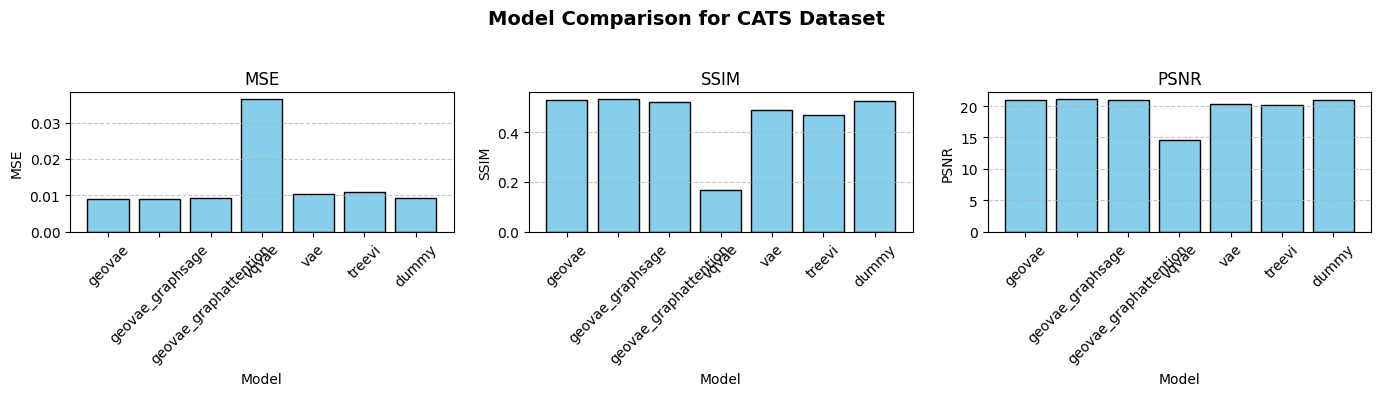

In [24]:
df = pd.read_csv('new_res.csv')

plot_metrics_for_dataset(df, 'cats')

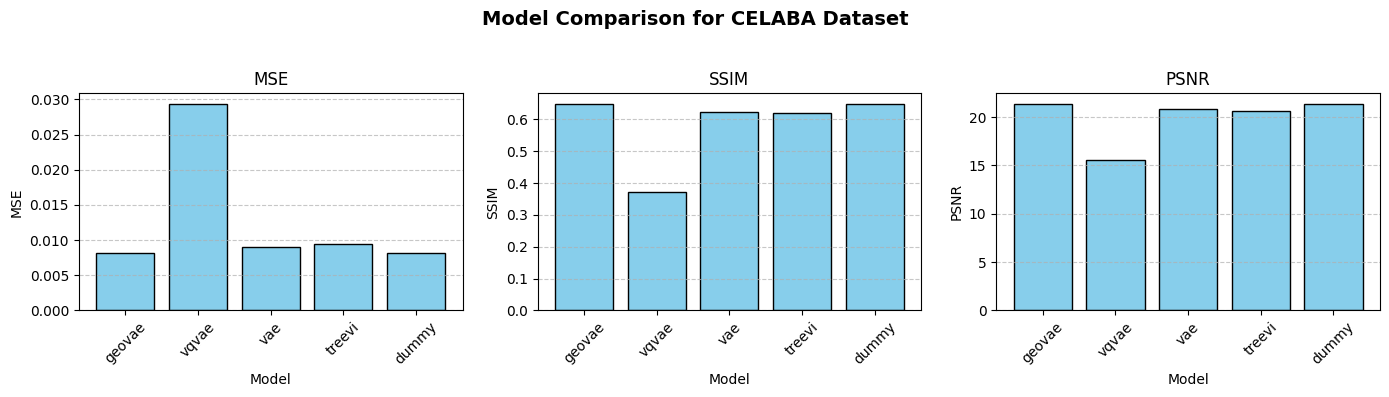

In [25]:
plot_metrics_for_dataset(df, 'celaba')

In [26]:
def plot_geovae_models_for_dataset(df, dataset_name, ymins=None):
    """
    Plots bar charts for MSE, SSIM, and PSNR for the given dataset,
    but includes only GEOVAE-related models (names starting with 'geovae').
    Maps model names to: GCN, GraphSAGE, GAT.
    """
    subset = df[(df['Dataset'] == dataset_name) & (df['Model'].str.startswith('geovae'))]
    if subset.empty:
        print(f"No GEOVAE models found for dataset '{dataset_name}'.")
        return

    name_map = {
        'geovae': 'GCN',
        'geovae_graphsage': 'GraphSAGE',
        'geovae_graphattention': 'GAT'
    }
    subset = subset.copy()
    subset['DisplayName'] = subset['Model'].map(name_map).fillna(subset['Model'])

    metrics = ['MSE', 'SSIM', 'PSNR']

    fig, axes = plt.subplots(1, 3, figsize=(10, 4))
    fig.suptitle(f'GEOVAE Variant Comparison for {dataset_name.upper()} Dataset', fontsize=14, fontweight='bold')

    for i, metric in enumerate(metrics):
        axes[i].bar(subset['DisplayName'], subset[metric], color='lightgreen', edgecolor='black')
        axes[i].set_title(metric)
        axes[i].set_xlabel('GEOVAE Variant')
        axes[i].set_ylabel(metric)
        axes[i].tick_params(axis='x', rotation=45)
        axes[i].grid(axis='y', linestyle='--', alpha=0.7)

        if ymins and metric in ymins:
            axes[i].set_ylim(bottom=ymins[metric])

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

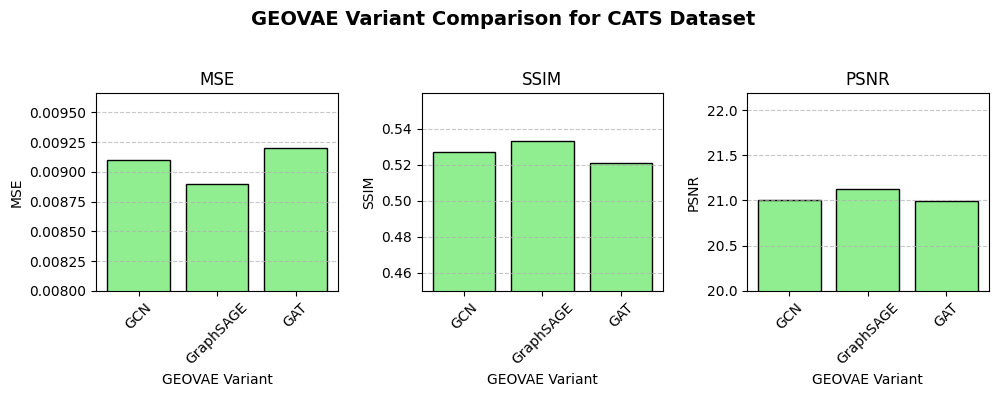

In [27]:
plot_geovae_models_for_dataset(df, 'cats', ymins={'MSE': 0.008, 'SSIM': 0.45, 'PSNR': 20})
